# False positives

author: steeve.laquitaine@epfl.ch  
last modified: 13-02-2024

**Method**:

* **delta_time (Δ𝑡)** = 1.3 ms: the time windows before and after the spike timestamp of a ground truth. When a the timestamp of a sorted unit falls within this time window, they coincide and the sorted timestamp is a hit.
* **chance level score**: see paper
* **dark (missed) units**: ground truth units with sorting accuracy below the chance agreement score (their best match with a sorted unit produce an agreement score below chance).
* **false positive units**: units which timestamps never hit the timestamps of the ground truth units wihin 50 microns of the probe: they never fall withing the delta_time window.


### Setup

Create or activate env `spikeinterf...`

In [1]:
%load_ext autoreload
%autoreload 2
import os 
from matplotlib import pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns 
import spikeinterface as si
from spikeinterface import comparison
import copy
proj_path = "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/"
os.chdir(proj_path)

from src.nodes.postpro.cell_matching import get_SpikeInterface_matching_object
from src.nodes.utils import get_config
from src.nodes.postpro.feateng import (add_firing_rates)
from src.nodes.analysis.failures import accuracy as acc
from src.nodes.metrics.metrics import get_firing_rate

# PARAMETERS
REC_DURATION = 600 # 10 minutes recording
DET = 0.8
CHANCE_THRESH = 0.1

# DATASETS

# NPX
# Synthetic
cfg_nb, _ = get_config("buccino_2020", "2020").values()
GT_nb_10m = cfg_nb["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
KS4_nb = cfg_nb["sorting"]["sorters"]["kilosort3"]["10m"]["output"]
REC_nb = cfg_nb["probe_wiring"]["full"]["output"]

# biophy spont
cfg_ns, _ = get_config("silico_neuropixels", "concatenated").values()
KS4_ns = cfg_ns["sorting"]["sorters"]["kilosort3"]["output"]
GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
REC_ns = cfg_ns["probe_wiring"]["full"]["output"]

# biophy evoked
cfg_ne, _ = get_config("silico_neuropixels", "stimulus").values()
KS4_ne = cfg_ne["sorting"]["sorters"]["kilosort3"]["output"]
GT_ne_10m = cfg_ne["sorting"]["simulation"]["ground_truth"]["10m"]["output"]
REC_ne = cfg_ne["probe_wiring"]["full"]["output"]

# FIGURE SETTINGS
COLOR_VIVO = (0.7, 0.7, 0.7)
COLOR_SILI = (0.84, 0.27, 0.2)
COLOR_STIM = (0.6, 0.75, 0.1)
BOX_ASPECT = 1                  # square fig
FIG_SIZE = (1,1)
plt.rcParams['figure.figsize'] = (2,1)
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6
plt.rcParams['lines.linewidth'] = 0.2
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.major.width'] = 0.3
plt.rcParams['xtick.minor.size'] = 0.1
plt.rcParams['xtick.major.size'] = 1.5
plt.rcParams['ytick.major.size'] = 1.5
plt.rcParams['ytick.major.width'] = 0.3
legend_cfg = {"frameon": False, "handletextpad": 0.1}
savefig_cfg = {"transparent":True}
# print(plt.rcParams.keys())

2024-08-26 10:47:12,229 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-26 10:47:12,356 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-26 10:47:12,360 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-26 10:47:12,429 - root - utils.py - get_config - INFO - Reading experiment config. - done
2024-08-26 10:47:12,430 - root - utils.py - get_config - INFO - Reading experiment config.
2024-08-26 10:47:12,495 - root - utils.py - get_config - INFO - Reading experiment config. - done


### Chance score

In [2]:
# calculate chance score for a 1 Hz sorted unit (spikes/secs)
fr_gt = 1
fr_s = 1
delta_time = 1.3  # in ms
rec_dur = 600  # recording duration

# calculate chance agreement score
# - chance probability of hits
# - chance score
p_chance_hit = acc.get_p_chance_hit(1 / 1000, 1.3)
chance_acc = acc.get_unit_chance_agreement_score(fr_gt, fr_s, 600, p_chance_hit)
chance_acc

0.0012999992676670962

### Define custom functions

In [137]:
def classify_sorted_unit_biases(agreem_mx, det):
    """_summary_

    Args:
        agreem_mx (_type_): _description_

    Returns:
        (dict):
        - "match" (pd.DataFrame): N ground truth unit indices, N best-match sorted units

    """

    # note: with this approach (BEST matching approach), the same sorted unit can be paired with more than one true unit
    # we only keep the pairings with highest agreement scores
    # true-sorted unit pairing
    pairing = agreem_mx.T.idxmax(axis=1)
    pairing = pairing.to_frame()
    pairing.columns = ["sorted"]

    # add agreement score
    accuracy = agreem_mx.T.max(axis=1)
    pairing["accuracy"] = accuracy

    # check if the only sorted unit paired with this true unit
    sorted_ids = agreem_mx.index

    df = copy.copy(pairing.iloc[0, :].to_frame().T)
    false_positives = []

    # else keep the pairing with highest agreement score
    # loop over all sorted single unit units
    for ix in range(len(sorted_ids)):
        # case the sorted unit was paired with a ground truth unit
        if any(pairing["sorted"] == sorted_ids[ix]):
            sorted_pairings = pairing[pairing["sorted"] == sorted_ids[ix]].sort_values(
                by="accuracy", ascending=False
            )
            # take max pairing (first row)
            df = pd.concat([df, sorted_pairings.iloc[0, :].to_frame().T])
        else:
            # case the sorted unit was paired with none of the ground truth units
            false_positives.append(sorted_ids[ix])

    df = df[1:]
    df["sorted"] = df["sorted"].astype(int)

    # count biases
    n_good = sum(df["accuracy"] >= det)
    n_poor = sum((df["accuracy"] >= CHANCE_THRESH) & (df["accuracy"] < det))
    n_below_chance = sum((df["accuracy"] > 0) & (df["accuracy"] < CHANCE_THRESH))
    n_false_pos = len(false_positives)

    # sanity check
    # assert n_good + n_poor + n_below_chance + n_false_pos == len(
    #     sorted_ids
    # ), "They must match"
    return {
        "n_good": n_good,
        "n_poor": n_poor,
        "n_below_chance": n_below_chance,
        "n_false_pos": n_false_pos,
        "match": pairing,
    }


# def get_sorting_quality(scores: pd.DataFrame):
#     """qualify sorted units

#     Args:
#         scores (_type_): agreement scores for N rows
#         of sorted units x M columns of ground truth units

#     Returns:
#         dict: _description_
#     """

#     # The same sorted unit can be paired with more than one true unit
#     # we only keep the pairings with highest agreement scores
#     # true-sorted unit pairing
#     match = scores.T.idxmax(axis=1)
#     match = match.to_frame()
#     match.index.name = "true"
#     match.columns = ["sorted"]

#     # add agreement score
#     accuracy = scores.max(axis=0)
#     match["accuracy"] = accuracy

#     sorted_ids = scores.index

#     df = pd.DataFrame()
#     false_positives = []

#     # else keep the match with highest agreement score
#     # loop over all sorted single unit units
#     for ix in range(len(sorted_ids)):
#         # case the sorted unit was paired with a ground truth unit
#         if any(match["sorted"] == sorted_ids[ix]):
#             sorted_matchs = match[match["sorted"] == sorted_ids[ix]].sort_values(
#                 by="accuracy", ascending=False
#             )
#             # take max pairing (first row)
#             df = pd.concat([df, sorted_matchs.iloc[0, :].to_frame().T])
#         else:
#             # case the sorted unit was paired with none of the ground truth units
#             false_positives.append(sorted_ids[ix])

#     df["sorted"] = df["sorted"].astype(int)

#     # count biases
#     n_good = sum(df["accuracy"] >= DET_THRESH)
#     n_poor = sum((df["accuracy"] >= CHANCE_THRESH) & (df["accuracy"] < DET_THRESH))
#     n_below_chance = sum((df["accuracy"] > 0) & (df["accuracy"] < CHANCE_THRESH))
#     n_false_pos = len(false_positives)

#     # sanity check
#     # assert n_good + n_poor + n_below_chance + n_false_pos == len(
#     #    sorted_ids
#     # ), "They must match"
#     return {
#         "n_good": n_good,
#         "n_poor": n_poor,
#         "n_below_chance": n_below_chance,
#         "n_false_pos": n_false_pos,
#         "match": match,
#     }


def plot_sorting_quality(ax, scores_by_exp):

    # set all colors
    colors = [
        [0.7, 0.1, 0.1],  # "good" (strong red)
        [1, 0.85, 0.85],  # "poor" (pink)
        [0.95, 0.95, 0.95],  # "below chance"
        "w",  # "false positive"
    ]

    # count sorted unit biases for each dataset
    # agreem_names = ["Buccino", "Marques", "Horvath", "Evoked"]
    exps = ["NS"]

    df2 = pd.DataFrame()

    for ix in range(len(exps)):
        out = get_sorting_quality(scores_by_exp[ix])
        df2[exps[ix]] = [
            out["n_good"],
            out["n_poor"],
            out["n_below_chance"],
            out["n_false_pos"],
        ]
    df2.index = ["good", "poor", "below chance", "false positive"]
    df2_ratio = df2 / df2.sum()

    ax = (df2_ratio).T.plot.bar(
        ax=ax,
        stacked=True,
        color=colors,
        width=0.9,
        edgecolor=[0, 0, 0],
        linewidth=0.2,
    )

    # set axis legend
    ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
    y_axis = ax.axes.get_yaxis()
    y_axis.set_visible(False)
    ax.set_xticklabels(df2_ratio.columns, rotation=45, ha="right")
    ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

    ax.legend(
        df2.index,
        ncol=1,
        loc="lower left",
        bbox_to_anchor=(1, 0),
        frameon=False,
        handletextpad=0.6,
    )
    plt.tight_layout()


def get_true_unit_best_match(scores: pd.DataFrame):
    """_summary_

    Some scores can be 0, if they were the best found

    Args:
        scores (pd.DataFrame): _description_

    Returns:
        _type_: _description_
    """
    # the same sorted unit can be paired with more than one true unit
    # we keep the pairings with highest agreement scores
    # true-sorted unit pairing
    match = scores.idxmax(axis=0)
    match = match.to_frame()
    match.columns = ["sorted"]
    match.index.name = "true"

    # record agreement score
    match["accuracy"] = scores.max(axis=0)
    return match


def count_match(match: pd.DataFrame, sorted: int):
    """count the number of true units
    one sorted unit matches

    Args:
        match (pd.DataFrame):
        - index: true units id
        - columns:
        - - "sorted": best-match sorted unit id
        - - "accuracy": best-match agreement score
        (true unit sorting accuracy)
    """
    return sum(match["sorted"] == sorted)


def get_best_matched_true_unit(match, s_id):
    """get true unit matchs

    Args:
        match (_type_): _description_
        s_id (_type_): _description_

    Returns:
        _type_: _description_
    """
    units = match[match["sorted"] == s_id].index.values
    if len(units) == 1:
        units = units[0]
    return units


def get_all_matched_true_unit(s_id, scores):
    """get all true unit matchs

    Args:
        match (_type_): _description_
        s_id (_type_): _description_

    Returns:
        _type_: _description_
    """
    return np.array(scores.columns[scores.loc[s_id, :] > 0])


def get_chance_score(gt_id, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time):
    fr_s = get_firing_rate(s_id, Sorting_ns, duration)
    fr_gt = get_firing_rate(gt_id, SortingTrue_ns, duration)
    p_chance_hit = acc.get_p_chance_hit(min(fr_gt, fr_s) / 1000, delta_time)
    return acc.get_unit_chance_agreement_score(fr_gt, fr_s, duration, p_chance_hit)


def get_score(scores, s_id, gt_id):
    try:
        return scores.loc[s_id, gt_id]
    except:
        from ipdb import set_trace

        set_trace()


def is_score_at_chance(
    scores, s_id, gt_id, Sorting_ns, SortingTrue_ns, duration, delta_time
):
    score = get_score(scores, s_id, gt_id)
    chance = get_chance_score(
        gt_id, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time
    )
    return score <= chance


def are_all_scores_at_chance(
    s_id, gt_id, scores, Sorting_ns, SortingTrue_ns, duration, delta_time
):
    """check whether a sorted unit agreement scores with the many
    ground truth units it matches are all at chance (it is a false
    positive)

    Args:
        s_id (_type_): sorted unit id
        gt_id (_type_): ground truth unit id
        scores (_type_): _description_
        match (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_

    Returns:
        _type_: _description_
    """

    # make an 1D array
    gt_id = make_1darray(gt_id)

    # start counting scores below chance
    d = 0
    for _, g_i in enumerate(gt_id):
        d += is_score_at_chance(
            scores, s_id, g_i, Sorting_ns, SortingTrue_ns, duration, delta_time
        )
    return d == len(gt_id)


def make_1darray(gt_id):
    if isinstance(gt_id, np.ndarray):
        return gt_id
    else:
        return np.array([gt_id])


def is_oversplitter_1(
    scores, match, s_id, gt_id, Sorting_ns, SortingTrue_ns, duration, delta_time
):
    """check when sorted unit matches only one ground truth unit

    Args:
        scores (_type_): _description_
        match (_type_): _description_
        s_id (_type_): _description_
        gt_id (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_

    Returns:
        _type_: _description_
    """
    # find all sorted units that match this ground truth unit
    sorteds = match[match.index == gt_id]["sorted"].values.tolist()

    d = 0
    # loop over sorted unit match
    for _, s_i in enumerate(sorteds):

        # check for other sorted unit match
        # than the target match s_id
        if not s_i == s_id:
            d += is_score_at_chance(
                scores,
                s_i,
                gt_id,
                Sorting_ns,
                SortingTrue_ns,
                duration,
                delta_time,
            )
    return d > 0


def is_oversplitter_2(
    s_id, gt_id, scores, match, Sorting_ns, SortingTrue_ns, duration, delta_time
):
    """check when sorted unit matches many ground truth units

    Args:
        s_id (_type_): _description_
        scores (_type_): _description_
        match (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_

    Returns:
        _type_: _description_
    """
    d = 0
    for _, g_i in enumerate(gt_id):
        d += is_oversplitter_1(
            scores,
            match,
            s_id,
            g_i,
            Sorting_ns,
            SortingTrue_ns,
            duration,
            delta_time,
        )
    return d > 0


def is_poor(det, scores, gt_id, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time):
    """is poor (score between chance and threshold for "good" (80%))

    Args:
        scores (_type_): _description_
        gt_id (_type_): _description_
        s_id (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_

    Returns:
        _type_: _description_
    """
    chance = get_chance_score(
        gt_id, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time
    )
    score = get_score(scores, s_id, gt_id)
    return (score > chance) & (score < det)


def is_poor_2(
    s_id, gt_id, scores, Sorting_ns, SortingTrue_ns, duration, delta_time, det
):
    """is poor when sorted unit matches many ground truth units
    (all its scores with the ground truth are below the "good" threshold
    and it has at least one score with a ground truth above chance

    Args:
        s_id (_type_): _description_
        match (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_
        det (_type_): _description_

    Returns:
        _type_: _description_
    """
    chance_all = []
    score_all = []

    for _, g_i in enumerate(gt_id):
        chance_all.append(
            get_chance_score(
                g_i, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time
            )
        )
        score_all.append(get_score(scores, s_id, g_i))

    # all scores are below DET
    test_1 = all(np.array(score_all) < det)

    # at least one score is above chance
    test_2 = any(np.array(score_all) > np.array(chance_all))
    return test_1 & test_2


def is_overmerger_2(
    s_id, gt_id, scores, Sorting_ns, SortingTrue_ns, duration, delta_time
):
    """is an overmerger: the sorted unit matches more than one ground
    truth with above chance scores

    Args:
        s_id (_type_): _description_
        match (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get there scores
    chance_all = []
    score_all = []

    for _, g_i in enumerate(gt_id):
        # get chance scores
        chance_all.append(
            get_chance_score(
                g_i, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time
            )
        )
        # get scores
        score_all.append(get_score(scores, s_id, g_i))
    return sum(np.array(score_all) > np.array(chance_all)) > 1


def is_good(det, scores, gt_id, s_id):
    """is good (score above good unit threshold (80%)

    Args:
        scores (_type_): _description_
        gt_id (_type_): _description_
        s_id (_type_): _description_
        det (float); good unit lower agreement score threshold

    Returns:
        _type_: _description_
    """
    score = get_score(scores, s_id, gt_id)
    return score >= det


def is_good_2(s_id, gt_id, scores, Sorting_ns, SortingTrue_ns, duration, delta_time):
    """is sorted unit good: it matches one ground truth with > 80% and no
    other ground truth with

    Args:
        s_id (_type_): _description_
        scores (_type_): _description_
        match (_type_): _description_
        Sorting_ns (_type_): _description_
        SortingTrue_ns (_type_): _description_
        duration (_type_): _description_
        delta_time (_type_): _description_

    Returns:
        _type_: _description_
    """
    # get there scores
    chance_all = []
    score_all = []

    for _, g_i in enumerate(gt_id):
        # get chance scores
        chance_all.append(
            get_chance_score(
                g_i, s_id, Sorting_ns, SortingTrue_ns, duration, delta_time
            )
        )
        # get scores
        score_all.append(get_score(scores, s_id, g_i))

    # tests
    test_1 = sum(np.array(score_all) >= DET) == 1
    test_2 = sum(np.array(score_all) > np.array(chance_all)) == 1
    return test_1 & test_2


def set_df(df, sorted, true, quality, score):
    df.loc[sorted, "sorted"] = sorted
    df.loc[sorted, "true"] = true
    df.loc[sorted, "score"] = score
    qual = df.loc[sorted, "quality"]
    # record quality if nan (empty)
    # else append new quality
    if isinstance(qual, str):
        df.loc[sorted, "quality"] += quality
    else:
        df.loc[sorted, "quality"] = quality
    return df


def get_scores(
    SortingTrue,
    Sorting,
    delta_time: float,
):
    comp = comparison.compare_sorter_to_ground_truth(
        SortingTrue,
        Sorting,
        exhaustive_gt=True,
        delta_time=delta_time,
    )
    # return comp.agreement_scores.max(axis=1).sort_values(ascending=False).values
    return comp.agreement_scores

## False positives

In [4]:
# load SortingExtractors
SortingTrue_ns = si.load_extractor(GT_ns_10m)
Sorting_ns = si.load_extractor(KS4_ns)
Rec_ns = si.load_extractor(REC_ns)

# get scores (N sorted units rows x N true units columns)
scores_ns = get_scores(SortingTrue_ns, Sorting_ns, 1.3)
scores_ns = scores_ns.T

# curate (get single-unit only)
scores_ns = scores_ns.loc[
    Sorting_ns.unit_ids[Sorting_ns.get_property("KSLabel") == "good"], :
]

scores_by_exp = [scores_ns]

/gpfs/bbp.cscs.ch/project/proj85/scratch/laquitai/4_preprint_2023/envs/spikinterf0_100_5/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.96.1 is recommended
  warnings.warn(


In [21]:
# compute sorting quality
out = classify_sorted_unit_biases(scores_ns, DET)

**Method**:

* For each true unit we find its best-match sorted unit
* calculate chance level for all units is pairs is consuming-
* all NaN scores are sorted units' will many ground truth matches.
* 15 minutes


In [146]:
scores = scores_ns

match = get_true_unit_best_match(scores_ns)

# qualify all sorted units
duration = min(Rec_ns.get_total_duration(), REC_DURATION)
sorted_ids = scores.index
false_pos = []

df = pd.DataFrame({"sorted": [], "true": [], "quality": np.nan})

many = []
ones = []
test1 = []
test2 = []

sorted_copy = copy.copy(sorted_ids)

# qualify each sorted single-unit
for _, s_id in enumerate(sorted_ids):

    # get all ground truths matched by this sorted unit
    gt_id = get_all_matched_true_unit(s_id, scores)

    # false positive: all scores are at chance
    if are_all_scores_at_chance(
        s_id, gt_id, scores, Sorting_ns, SortingTrue_ns, duration, delta_time
    ):
        df = set_df(df, s_id, np.nan, "+ false_pos ", np.nan)

    else:

        # if it best-detected a true unit
        if s_id in match["sorted"].values:

            # get best-matched ground truths
            gt_id = get_best_matched_true_unit(match, s_id)

            # if it detected a single true unit
            # - can be a false positive
            # - poor (chance - 80%)
            # - an oversplitter
            # - good (above 80%)
            # - cannot be an overmerger
            if count_match(match, s_id) == 1:

                gt_id = int(gt_id)
                s_id = int(s_id)
                score = get_score(scores, s_id, gt_id)

                # poor (chance < score < DET)
                if is_poor(
                    DET,
                    scores,
                    gt_id,
                    s_id,
                    Sorting_ns,
                    SortingTrue_ns,
                    duration,
                    delta_time,
                ):
                    df = set_df(df, s_id, gt_id, "+ poor ", score)

                # oversplitter
                if is_oversplitter_1(
                    scores,
                    match,
                    s_id,
                    gt_id,
                    Sorting_ns,
                    SortingTrue_ns,
                    duration,
                    delta_time,
                ):
                    df = set_df(df, s_id, gt_id, "+ oversplitter ", score)

                # good
                if is_good(DET, scores, gt_id, s_id):
                    df = set_df(df, s_id, gt_id, "+ good ", score)

                ones.append(s_id)

            # many ground truths are matched
            else:

                # oversplitter
                if is_oversplitter_2(
                    s_id,
                    gt_id,
                    scores,
                    match,
                    Sorting_ns,
                    SortingTrue_ns,
                    duration,
                    delta_time,
                ):
                    df = set_df(df, s_id, np.nan, "+ oversplitter ", np.nan)

                # overmerger
                if is_overmerger_2(
                    s_id,
                    gt_id,
                    scores,
                    Sorting_ns,
                    SortingTrue_ns,
                    duration,
                    delta_time,
                ):
                    df = set_df(df, s_id, np.nan, "+ overmerger ", np.nan)

                # poor
                if is_poor_2(
                    s_id,
                    gt_id,
                    scores,
                    Sorting_ns,
                    SortingTrue_ns,
                    duration,
                    delta_time,
                    DET,
                ):
                    df = set_df(df, s_id, np.nan, "+ poor ", np.nan)

                # good
                if is_good_2(
                    s_id,
                    gt_id,
                    scores,
                    Sorting_ns,
                    SortingTrue_ns,
                    duration,
                    delta_time,
                ):
                    df = set_df(df, s_id, np.nan, "+ good ", np.nan)

        # if it was not the best match to any true unit
        if not s_id in match["sorted"].values:

            many.append(s_id)

            gt_id = get_all_matched_true_unit(s_id, scores)

            # # if it matched one true unit

            # oversplitter: it matched more than
            # else:

# unit-test
# assert len(df) == len(sorted_ids), "some sorted units were not qualified"

In [148]:
df.quality.unique()

array(['+ overmerger + poor ', '+ poor '], dtype=object)

## TEST

In [140]:
s_id = 326  # 326  # 326

False

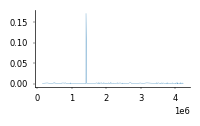

In [71]:
units

1979150

In [26]:
gt_id

[1979150]

/tmp/ipykernel_234397/4156573646.py:412: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


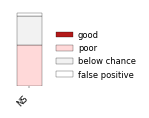

In [113]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(0.5, 1))
plot_sorting_quality(ax, scores_by_exp)

/tmp/ipykernel_236392/888313127.py:53: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


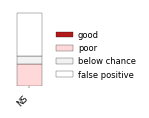

In [16]:
# set all colors
colors = [
    [0.7, 0.1, 0.1],  # "good" (strong red)
    [1, 0.85, 0.85],  # "poor" (pink)
    [0.95, 0.95, 0.95],  # "below chance"
    "w",  # "false positive"
]

# count sorted unit biases for each dataset
# agreem_names = ["Buccino", "Marques", "Horvath", "Evoked"]
exps = ["NS"]

df2 = pd.DataFrame()

for ix in range(len(exps)):
    out = classify_sorted_units(exp_scores[ix])
    df2[exps[ix]] = [
        out["n_good"],
        out["n_poor"],
        out["n_below_chance"],
        out["n_false_pos"],
    ]
df2.index = ["good", "poor", "below chance", "false positive"]
df2_ratio = df2 / df2.sum()

fig, axis = plt.subplots(1, 1, figsize=(0.5, 1))
ax = (df2_ratio).T.plot.bar(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.9,
    edgecolor=[0, 0, 0],
    linewidth=0.2,
)


# set axis legend
ax.spines[["left", "right", "top", "bottom"]].set_visible(False)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xticklabels(df2_ratio.columns, rotation=45, ha="right")
ax.set_ylabel("Sorting biases (ratio)", fontsize=9)

ax.legend(
    df2.index,
    ncol=1,
    loc="lower left",
    bbox_to_anchor=(1, 0),
    frameon=False,
    handletextpad=0.6,
)

plt.tight_layout()

# # save figures
# plt.savefig(
#     "/gpfs/bbp.cscs.ch/project/proj85/home/laquitai/preprint_2023/figures/3_bias/svg/sorted_unit_biases_ks3.svg",
#     **savefig_cfg,
# )

### SUPPLREMENTARY: For a comprehensive descriptions of biases for ground truth and sorted units

In [161]:
overmerging_matx_2 = agreem_mx_m
det_thresh = 0.8
chance = 0.1

# create masks
mask_above_det = overmerging_matx_2 >= det_thresh
mask_below_chance = overmerging_matx_2 <= chance
mask_in_between = np.logical_and(
    overmerging_matx_2 < det_thresh, overmerging_matx_2 > chance
)
mask_entirely_missed = overmerging_matx_2 == 0

# implement tree to classify ground truths
# find ground truth (cols) with one mask_above_det=True and other mask_below_chance = True

gt_classes = []
df = pd.DataFrame(
    data=np.array([[0], [0], [0], [0]]).T,
    columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
)

# loop over ground truth units
for gt_i in range(overmerging_matx_2.shape[1]):

    # check if that ground truth has a single sorted unit
    # with an agreement score above detection threshold
    if any(mask_above_det.iloc[:, gt_i]):

        # get this ground truth detection stata
        is_detected = mask_above_det.iloc[:, gt_i]
        detected_loc = np.where(is_detected)[0]
        detected_id = is_detected.index[detected_loc]

        # get other correlated unit ids
        other_sorted_unit_ids = is_detected.drop(index=detected_id).index

        # get this ground truth below chance stata
        is_below_chance = mask_below_chance.iloc[:, gt_i]

        # check if all other sorted units are below chance
        if all(is_below_chance.loc[other_sorted_unit_ids]):
            gt_classes.append("well detected")

            # pair true and sorted units
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        [overmerging_matx_2.columns[gt_i]],
                        [detected_id[0]],
                        ["well detected"],
                        ["good"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])

        # if another unit has an agreement score
        # above chance level, it is: well detected + correlated unit
        else:
            gt_classes.append("well detected, correlated")

            # pair true and the well detected sorted unit
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        [overmerging_matx_2.columns[gt_i]],
                        [detected_id[0]],
                        ["well detected, correlated"],
                        ["good"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])

            # pair true and the other redundant sorted unit
            n_redundants = len(other_sorted_unit_ids.tolist())
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        n_redundants * [overmerging_matx_2.columns[gt_i]],
                        other_sorted_unit_ids.tolist(),
                        n_redundants * ["poorly detected"],
                        n_redundants * ["redundant"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])

    # case where ground truth matches only one sorted unit
    # with a score b/w detection and chance and
    # other units below chance
    # no scores are above detection
    elif (sum(mask_in_between.iloc[:, gt_i]) == 1) and (
        any(mask_above_det.iloc[:, gt_i]) == False
    ):
        gt_classes.append("poorly detected")

        # pair units
        unit_id = overmerging_matx_2.index[
            np.where(mask_in_between.iloc[:, gt_i] == 1)[0][0]
        ]
        df2 = pd.DataFrame(
            data=np.array(
                [
                    [overmerging_matx_2.columns[gt_i]],
                    [unit_id],
                    ["poorly detected"],
                    ["poor unit"],
                ]
            ).T,
            columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
        )
        df = pd.concat([df, df2])

    # case a true unit is associated is a sorted unit with score
    # between detection and chance that is associated with other
    # true units with scores between detection and chances
    elif sum(mask_in_between.iloc[:, gt_i]) > 1:
        gt_classes.append("oversplit")

        # pair units
        unit_ids = overmerging_matx_2.index[
            np.where(mask_in_between.iloc[:, gt_i])[0].tolist()
        ].tolist()
        n_oversplitters = len(unit_ids)

        df2 = pd.DataFrame(
            data=np.array(
                [
                    n_oversplitters * [overmerging_matx_2.columns[gt_i]],
                    unit_ids,
                    n_oversplitters * ["oversplit"],
                    n_oversplitters * ["oversplitters"],
                ]
            ).T,
            columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
        )
        df = pd.concat([df, df2])

    # check that all sorted units have scores below
    # chance
    elif all(mask_below_chance.iloc[:, gt_i]):
        if all(mask_entirely_missed.iloc[:, gt_i]):
            gt_classes.append("missed")

            # pair units
            df2 = pd.DataFrame(
                data=np.array(
                    [
                        [overmerging_matx_2.columns[gt_i]],
                        [np.nan],
                        ["missed"],
                        [np.nan],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])
        else:
            gt_classes.append("below chance")
            unit_ids = overmerging_matx_2.index[
                np.where(
                    (overmerging_matx_2.iloc[:, gt_i] <= chance)
                    * (overmerging_matx_2.iloc[:, gt_i] > 0)
                )[0]
            ].tolist()
            n_below_chance = len(unit_ids)

            df2 = pd.DataFrame(
                data=np.array(
                    [
                        n_below_chance * [overmerging_matx_2.columns[gt_i]],
                        unit_ids,
                        n_below_chance * ["below chance"],
                        n_below_chance * ["below chance"],
                    ]
                ).T,
                columns=["ground truth", "sorted", "ground truth bias", "sorted bias"],
            )
            df = pd.concat([df, df2])


# Detect overmerged units and combinations -------------

# if one of its sorted units with score between
# detection and chance has also a score between
# detection and chance with another true unit
# the true unit is overmerged (with another true unit)
true_units_loc = np.where(mask_in_between.sum(axis=0) >= 1)[0]
true_units = mask_in_between.columns[true_units_loc]
gt_overmerged = dict()

for gt_i in range(len(true_units_loc)):
    target_true_units_mx = mask_in_between.iloc[:, true_units_loc]
    sorted_u = np.where(target_true_units_mx.iloc[:, gt_i])[0]

    # check overmerged (that sorted unit merges other true units)
    if any(mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1):
        overmerged_bool = mask_in_between.iloc[sorted_u, :].sum(axis=1) > 1
        overmerging_sorted = overmerged_bool.index[
            np.where(overmerged_bool)[0]
        ].to_list()
        gt_overmerged[true_units[gt_i]] = overmerging_sorted

# what other biases do overmerged units have?
all_true_units = overmerging_matx_2.columns
gt_classes_df = pd.DataFrame(data=gt_classes, index=all_true_units.to_list())
print("combination of biases:", np.unique(gt_classes_df.loc[gt_overmerged.keys(), :]))

# label combination of biases
gt_classes_df.loc[gt_overmerged.keys(), :] = gt_classes_df.loc[
    gt_overmerged.keys(), :
].apply(lambda x: x + ", overmerged")

# poorly detected + overmerged units are poorly detected because overmerged so simply overmerged
gt_classes_df[gt_classes_df == "poorly detected, overmerged"] = "overmerged"
df = df[1:]

combination of biases: ['oversplit' 'poorly detected']


In [203]:
df

,ground truth,sorted,ground truth bias,sorted bias
0,1527208,99,below chance,below chance
1,1527208,117,below chance,below chance
2,1527208,124,below chance,below chance
3,1527208,164,below chance,below chance
4,1527208,198,below chance,below chance
...,...,...,...,...
0,3547327,nan,missed,nan
0,1509317,nan,missed,nan
0,1514245,nan,missed,nan
0,2696195,nan,missed,nan


### A sorted unit can show several biases (with different ground truth units)

In [204]:
ix = 20

sorted_ids = df["sorted"].unique()
df[df["sorted"] == sorted_ids[ix]]["sorted bias"].unique()

array(['below chance', 'redundant', 'poor unit'], dtype=object)

# references

(1) https://neuronaldynamics.epfl.ch/online/Ch7.S2.html